This Notebook is a library of functions for numerics of the incoherence simulations.

In [1]:
using BSON: @load
using Flux
using Flux.Optimise
using Flux.Optimise: update!
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Zygote
using FFTW
using Distributions
using SparseArrays
using JLD

In [35]:
"""
    optimise(init_z, loss, opt, tolerance, [out_toggle = 0,][max_iter = 1_000_000])

    Optimization that stops when the gradient is small enough
"""
function optimise(opt, loss; init, tolerance, out_toggle = 0, max_iter = 500_000)
    tol2 = tolerance^2
    z = init
    ps = Flux.params(z)
    iter=1
    succ_error = Inf
    while succ_error > tol2 
        if iter > max_iter
            @warn "Max num. iterations reached"
            return nothing
        end
        grads = gradient(() -> loss(z), ps)
        update!(opt, z, grads[z])
        succ_error = sum(abs2, grads[z])
        if out_toggle != 0 && iter % out_toggle == 0
            println("====> In Gradient: Iteration: $iter grad_size: $(sqrt(succ_error)) tolerance: $tolerance  Loss: ", string(loss(z)))
        end
        iter += 1
    end
    return z
end

optimise

In [3]:
function matrix_alignment(mat, basis)
    coherence = 0
    for v in eachcol(basis)
        guess = dot(mat*transpose(mat)*v, v)/ (norm(mat*transpose(mat)*v) * norm(v))
        coherence = max(guess, coherence)
    end
    return coherence
end

function get_rand_model(k,mid,n)
    W₂ = randn(n, mid)/sqrt(n)
    W₁ = randn(mid,k)/sqrt(mid)
    return x -> W₂*relu.(W₁*x)
end

function get_aligned_models(k,mid,n, β_array)
    W₁ = randn(mid, k)/sqrt(mid)
    full_F = dct(diagm(ones(n)),2)
    F = full_F[:,1:mid]
    A = randn(n, mid)/sqrt(n)
    models  = []
    for β in β_array
        W₂ = β*F + (1-β)*A
        push!(models, (x -> W₂*relu.(W₁*x), matrix_alignment(W₂, full_F)))
    end
    return models
end

get_aligned_models (generic function with 1 method)

In [54]:
function recover_signal(measurements, measure, model, code_dim)
    function loss(signal_guess)
        return sum(abs2, measure(model(signal_guess)) - measurements)
    end
    opt_code = optimise( Flux.Optimise.Descent(4e-5), loss, init=randn(code_dim)/sqrt(code_dim), tolerance=1e-6, out_toggle=20000)
    return opt_code != nothing ? model(opt_code) : nothing
end

recover_signal (generic function with 1 method)

In [ ]:
k=12
mid=15
n=50
aimed_m = 20
model = get_aligned_models(k, mid, n, [1.0])[1][1]
x₀ = model(randn(k)/sqrt(k))

m, A = sample_fourier(aimed_m, n)
y = A*x₀
println("signal norm: ", norm(x₀))
println("with measurements norm: ", norm(y))
x̂ = recover_signal(y, x -> A*x, model, k)
#println("recovered: ", x̂, " with measurements ", A*x̂)
println("norm of the error: ", norm(x̂ - x₀))
println("norm of recovered: ", norm(x̂))
#does not seem to work with gaussian.

In [ ]:
size(A)

In [52]:
function recovery_error(x₀, model, A, k)
    y = A*x₀
    x̂ = recover_signal(y, x -> A*x, model, k)
    if x̂ == nothing
        return nothing
    end
    return norm(x̂ - x₀)
end

recovery_error (generic function with 1 method)

In [53]:
function sample_fourier(aimed_m, n)
    F = dct(diagm(ones(n)),2)
    sampling = rand(Bernoulli(aimed_m/n), n)
    true_m = sum(sampling)
    return (true_m, F[sampling,:])
end

sample_fourier (generic function with 1 method)

In [17]:
β_array = 0:0.5:1
num_signals = 2
k=15
mid=20
n=100
aimed_m = 35
plot_pairs = []
m, A = sample_fourier(aimed_m, n)

for (model, alignment) in get_aligned_models(k, mid,n, β_array)
    signal_errors = []
    for i in 1:num_signals
        x₀ = randn(n)/sqrt(n)
        push!(signal_errors, recovery_error(x₀, model, A, k))
    end
    push!(plot_pairs, (alignment, copy(signal_errors)))
end


====> In Gradient: Iteration: 20000 grad_size: 0.0001952128224900819 tolerance: 1.0e-6  Loss: 0.27906313435738805
====> In Gradient: Iteration: 40000 grad_size: 5.856072974338081e-5 tolerance: 1.0e-6  Loss: 0.27903617339706555
====> In Gradient: Iteration: 60000 grad_size: 6.035352629912418e-6 tolerance: 1.0e-6  Loss: 0.27903215273330695
====> In Gradient: Iteration: 80000 grad_size: 1.988323189738787e-6 tolerance: 1.0e-6  Loss: 0.2790318330509561


In [55]:
function experiment_1()
    β_array = 0:0.05:1
    num_signals = 10
    k=8
    mid=16
    n= 32
    aimed_m = 16
    plot_pairs = []
    m, A = sample_fourier(aimed_m, n)
    for (model, alignment) in get_aligned_models(k, mid,n, β_array)
        signal_errors = []
        for i in 1:num_signals
            x₀ = randn(n)/sqrt(n)
            push!(signal_errors, recovery_error(x₀, model, A, k))
        end
        push!(plot_pairs, (alignment, copy(signal_errors)))
    end
    return plot_pairs
end

experiment_1 (generic function with 1 method)

In [ ]:
plot_pairs = experiment_1()

====> In Gradient: Iteration: 20000 grad_size: 6.075129912135128e-6 tolerance: 1.0e-6  Loss: 0.3352366891108532
====> In Gradient: Iteration: 40000 grad_size: 4.591219172808774e-6 tolerance: 1.0e-6  Loss: 0.3211911492121287
====> In Gradient: Iteration: 60000 grad_size: 3.5846039620405412e-6 tolerance: 1.0e-6  Loss: 0.3129194875447798
====> In Gradient: Iteration: 80000 grad_size: 2.87835073070835e-6 tolerance: 1.0e-6  Loss: 0.30774193033634856
====> In Gradient: Iteration: 100000 grad_size: 1.036602740794211e-5 tolerance: 1.0e-6  Loss: 0.2868459518695289
====> In Gradient: Iteration: 120000 grad_size: 5.771265682304706e-6 tolerance: 1.0e-6  Loss: 0.25666556263683393
====> In Gradient: Iteration: 140000 grad_size: 4.824958743784297e-6 tolerance: 1.0e-6  Loss: 0.24032765325832933
====> In Gradient: Iteration: 160000 grad_size: 3.6522198271102506e-6 tolerance: 1.0e-6  Loss: 0.23150519410309278
====> In Gradient: Iteration: 180000 grad_size: 2.956022955376718e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 9.964779524508077e-6 tolerance: 1.0e-6  Loss: 0.6210842184076643
====> In Gradient: Iteration: 40000 grad_size: 6.390693870544772e-6 tolerance: 1.0e-6  Loss: 0.5911183978826376
====> In Gradient: Iteration: 60000 grad_size: 5.374237463630806e-6 tolerance: 1.0e-6  Loss: 0.576542094846838
====> In Gradient: Iteration: 80000 grad_size: 4.605433209529434e-6 tolerance: 1.0e-6  Loss: 0.5664111682978317
====> In Gradient: Iteration: 100000 grad_size: 4.141607456824979e-6 tolerance: 1.0e-6  Loss: 0.558389698012828
====> In Gradient: Iteration: 120000 grad_size: 3.828271027949752e-6 tolerance: 1.0e-6  Loss: 0.5515601001406009
====> In Gradient: Iteration: 140000 grad_size: 3.591712961734433e-6 tolerance: 1.0e-6  Loss: 0.5455260670484613
====> In Gradient: Iteration: 160000 grad_size: 3.397375244014204e-6 tolerance: 1.0e-6  Loss: 0.5400946125750755
====> In Gradient: Iteration: 180000 grad_size: 5.186277950575363e-6 tolerance: 1.0e-6  Loss: 0.535156

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 5.2378556789378025e-6 tolerance: 1.0e-6  Loss: 0.5575628554379288
====> In Gradient: Iteration: 40000 grad_size: 5.9552731496392484e-6 tolerance: 1.0e-6  Loss: 0.549858775605879
====> In Gradient: Iteration: 60000 grad_size: 2.8699359190951195e-6 tolerance: 1.0e-6  Loss: 0.5459717322188836
====> In Gradient: Iteration: 80000 grad_size: 2.333815603127386e-6 tolerance: 1.0e-6  Loss: 0.543749626182733
====> In Gradient: Iteration: 100000 grad_size: 2.2934911424778045e-6 tolerance: 1.0e-6  Loss: 0.5412015346440234
====> In Gradient: Iteration: 120000 grad_size: 2.563047917699613e-6 tolerance: 1.0e-6  Loss: 0.5377159253031735
====> In Gradient: Iteration: 140000 grad_size: 2.004338489732184e-6 tolerance: 1.0e-6  Loss: 0.5353865827917562
====> In Gradient: Iteration: 160000 grad_size: 1.3271363609182226e-6 tolerance: 1.0e-6  Loss: 0.534077424096226
====> In Gradient: Iteration: 180000 grad_size: 1.0445015564087991e-6 tolerance: 1.0e-6  Loss: 0.5

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2425430875835384e-5 tolerance: 1.0e-6  Loss: 0.6893287132148725
====> In Gradient: Iteration: 40000 grad_size: 6.532300656710712e-6 tolerance: 1.0e-6  Loss: 0.66586818467868
====> In Gradient: Iteration: 60000 grad_size: 5.802933890718659e-6 tolerance: 1.0e-6  Loss: 0.6531493221275703
====> In Gradient: Iteration: 80000 grad_size: 5.326002819712831e-6 tolerance: 1.0e-6  Loss: 0.6427933130283487
====> In Gradient: Iteration: 100000 grad_size: 1.5027307174576167e-5 tolerance: 1.0e-6  Loss: 0.6366405582528212
====> In Gradient: Iteration: 120000 grad_size: 1.6705690958167855e-5 tolerance: 1.0e-6  Loss: 0.6051940778592358
====> In Gradient: Iteration: 140000 grad_size: 1.0664696058646002e-5 tolerance: 1.0e-6  Loss: 0.5928396781105832
====> In Gradient: Iteration: 160000 grad_size: 1.0064432080679687e-5 tolerance: 1.0e-6  Loss: 0.5867630431665122
====> In Gradient: Iteration: 180000 grad_size: 8.923635783986538e-6 tolerance: 1.0e-6  Loss: 0.5

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.951259809166154e-6 tolerance: 1.0e-6  Loss: 0.5144069438935014
====> In Gradient: Iteration: 40000 grad_size: 3.5860198844277294e-6 tolerance: 1.0e-6  Loss: 0.5038175136408684
====> In Gradient: Iteration: 60000 grad_size: 6.7946576913146095e-6 tolerance: 1.0e-6  Loss: 0.4992759581971462
====> In Gradient: Iteration: 80000 grad_size: 4.211591308863786e-6 tolerance: 1.0e-6  Loss: 0.4914621334629818
====> In Gradient: Iteration: 100000 grad_size: 3.7122052209733096e-6 tolerance: 1.0e-6  Loss: 0.484002084557614
====> In Gradient: Iteration: 120000 grad_size: 3.3727376179649915e-6 tolerance: 1.0e-6  Loss: 0.4782606966142754
====> In Gradient: Iteration: 140000 grad_size: 3.1242629811106045e-6 tolerance: 1.0e-6  Loss: 0.47365496487429193
====> In Gradient: Iteration: 160000 grad_size: 2.936471701922495e-6 tolerance: 1.0e-6  Loss: 0.4698505977715374
====> In Gradient: Iteration: 180000 grad_size: 2.791599033642652e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.4568933916084341e-5 tolerance: 1.0e-6  Loss: 0.5427491810306385
====> In Gradient: Iteration: 40000 grad_size: 8.365750819776798e-6 tolerance: 1.0e-6  Loss: 0.47514011213612245
====> In Gradient: Iteration: 20000 grad_size: 9.178127948709198e-6 tolerance: 1.0e-6  Loss: 0.4503471639915937
====> In Gradient: Iteration: 40000 grad_size: 3.620612259362871e-6 tolerance: 1.0e-6  Loss: 0.439384689655321
====> In Gradient: Iteration: 60000 grad_size: 3.141559151643617e-6 tolerance: 1.0e-6  Loss: 0.4337278163733512
====> In Gradient: Iteration: 80000 grad_size: 5.079922994421464e-6 tolerance: 1.0e-6  Loss: 0.42844253985976244
====> In Gradient: Iteration: 100000 grad_size: 2.413168028980254e-6 tolerance: 1.0e-6  Loss: 0.42232660692093155
====> In Gradient: Iteration: 120000 grad_size: 1.6903047083049211e-6 tolerance: 1.0e-6  Loss: 0.4204937220253433
====> In Gradient: Iteration: 140000 grad_size: 1.516098930724917e-6 tolerance: 1.0e-6  Loss: 0.41

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0897812234073063e-5 tolerance: 1.0e-6  Loss: 0.5151526096086841
====> In Gradient: Iteration: 40000 grad_size: 4.267297060245939e-6 tolerance: 1.0e-6  Loss: 0.4792287922875792
====> In Gradient: Iteration: 60000 grad_size: 2.4149441408754903e-6 tolerance: 1.0e-6  Loss: 0.4752561008513683
====> In Gradient: Iteration: 80000 grad_size: 2.2682291877955916e-6 tolerance: 1.0e-6  Loss: 0.474166861521064
====> In Gradient: Iteration: 100000 grad_size: 1.5914684057553353e-5 tolerance: 1.0e-6  Loss: 0.47377086963835957
====> In Gradient: Iteration: 120000 grad_size: 2.350446240885122e-6 tolerance: 1.0e-6  Loss: 0.4735139771136514
====> In Gradient: Iteration: 140000 grad_size: 1.949390852890803e-6 tolerance: 1.0e-6  Loss: 0.4733352763483806
====> In Gradient: Iteration: 160000 grad_size: 1.9081807726517405e-6 tolerance: 1.0e-6  Loss: 0.47320846785399207
====> In Gradient: Iteration: 180000 grad_size: 1.8776635445560118e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2187485162100817e-5 tolerance: 1.0e-6  Loss: 0.670278295370058
====> In Gradient: Iteration: 40000 grad_size: 4.145808278143848e-6 tolerance: 1.0e-6  Loss: 0.6425158149379706
====> In Gradient: Iteration: 60000 grad_size: 2.0614044269206787e-6 tolerance: 1.0e-6  Loss: 0.638302509431972
====> In Gradient: Iteration: 80000 grad_size: 1.4757716748672445e-6 tolerance: 1.0e-6  Loss: 0.6367956579448831
====> In Gradient: Iteration: 100000 grad_size: 1.1375746673440542e-6 tolerance: 1.0e-6  Loss: 0.6359494725167347
====> In Gradient: Iteration: 20000 grad_size: 1.081830714336834e-5 tolerance: 1.0e-6  Loss: 0.5126870359445103
====> In Gradient: Iteration: 40000 grad_size: 8.853440654826845e-6 tolerance: 1.0e-6  Loss: 0.49609776100850383
====> In Gradient: Iteration: 60000 grad_size: 8.148262905416103e-6 tolerance: 1.0e-6  Loss: 0.4880368469248526
====> In Gradient: Iteration: 80000 grad_size: 1.2165135347801078e-5 tolerance: 1.0e-6  Loss: 0.4806

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 5.367558356463121e-6 tolerance: 1.0e-6  Loss: 0.42012480035521416
====> In Gradient: Iteration: 40000 grad_size: 4.107587092054387e-6 tolerance: 1.0e-6  Loss: 0.4094491166776419
====> In Gradient: Iteration: 60000 grad_size: 3.47319717068645e-6 tolerance: 1.0e-6  Loss: 0.40231400705083326
====> In Gradient: Iteration: 80000 grad_size: 3.0071610631479475e-6 tolerance: 1.0e-6  Loss: 0.39709253872332245
====> In Gradient: Iteration: 100000 grad_size: 2.6553151214720632e-6 tolerance: 1.0e-6  Loss: 0.3931015513296876
====> In Gradient: Iteration: 120000 grad_size: 2.3817427950379766e-6 tolerance: 1.0e-6  Loss: 0.3899404733032166
====> In Gradient: Iteration: 140000 grad_size: 2.1623108236810636e-6 tolerance: 1.0e-6  Loss: 0.38736594227699994
====> In Gradient: Iteration: 160000 grad_size: 1.981130387917996e-6 tolerance: 1.0e-6  Loss: 0.3852241442169397
====> In Gradient: Iteration: 180000 grad_size: 1.8278525158534002e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 6.446296403775231e-6 tolerance: 1.0e-6  Loss: 0.4948256858320469
====> In Gradient: Iteration: 20000 grad_size: 2.16275900201126e-5 tolerance: 1.0e-6  Loss: 0.7053913247050784
====> In Gradient: Iteration: 40000 grad_size: 1.5399905050341745e-5 tolerance: 1.0e-6  Loss: 0.46355635954735613
====> In Gradient: Iteration: 60000 grad_size: 9.870630038316229e-6 tolerance: 1.0e-6  Loss: 0.3927259436263656
====> In Gradient: Iteration: 80000 grad_size: 5.7957538507849e-6 tolerance: 1.0e-6  Loss: 0.3701675248858373
====> In Gradient: Iteration: 100000 grad_size: 4.417516828612417e-6 tolerance: 1.0e-6  Loss: 0.3570296263438191
====> In Gradient: Iteration: 120000 grad_size: 3.831537658003643e-6 tolerance: 1.0e-6  Loss: 0.34917112572120995
====> In Gradient: Iteration: 140000 grad_size: 3.3748704946670596e-6 tolerance: 1.0e-6  Loss: 0.3431428023152054
====> In Gradient: Iteration: 160000 grad_size: 3.000767618983893e-6 tolerance: 1.0e-6  Loss: 0.3384

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2516497130050589e-5 tolerance: 1.0e-6  Loss: 0.5747520804848605
====> In Gradient: Iteration: 40000 grad_size: 8.088584879534434e-6 tolerance: 1.0e-6  Loss: 0.5247316595772068
====> In Gradient: Iteration: 60000 grad_size: 5.894663656438862e-6 tolerance: 1.0e-6  Loss: 0.5009089518485522
====> In Gradient: Iteration: 80000 grad_size: 4.586915236710305e-6 tolerance: 1.0e-6  Loss: 0.48737279607435396
====> In Gradient: Iteration: 100000 grad_size: 3.8145322518720177e-6 tolerance: 1.0e-6  Loss: 0.47918309375414675
====> In Gradient: Iteration: 120000 grad_size: 3.5614426661222856e-6 tolerance: 1.0e-6  Loss: 0.47439642687298267
====> In Gradient: Iteration: 140000 grad_size: 3.607922580909155e-6 tolerance: 1.0e-6  Loss: 0.4715861568838593
====> In Gradient: Iteration: 160000 grad_size: 3.977281007685879e-6 tolerance: 1.0e-6  Loss: 0.4698795365202885
====> In Gradient: Iteration: 180000 grad_size: 2.872197130310228e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.6047014940163345e-5 tolerance: 1.0e-6  Loss: 0.3701446121915954
====> In Gradient: Iteration: 40000 grad_size: 9.872146300246895e-6 tolerance: 1.0e-6  Loss: 0.290492214917594
====> In Gradient: Iteration: 60000 grad_size: 6.872346172407612e-6 tolerance: 1.0e-6  Loss: 0.25596868226091163
====> In Gradient: Iteration: 80000 grad_size: 6.49054488032565e-6 tolerance: 1.0e-6  Loss: 0.23751087945632188
====> In Gradient: Iteration: 100000 grad_size: 6.077887643024499e-6 tolerance: 1.0e-6  Loss: 0.22339899534837024
====> In Gradient: Iteration: 120000 grad_size: 3.850066039397345e-6 tolerance: 1.0e-6  Loss: 0.21139470761131512
====> In Gradient: Iteration: 140000 grad_size: 3.2548276060625243e-6 tolerance: 1.0e-6  Loss: 0.20642581538651703
====> In Gradient: Iteration: 160000 grad_size: 1.868127597993702e-6 tolerance: 1.0e-6  Loss: 0.20411585877863764
====> In Gradient: Iteration: 180000 grad_size: 1.7971192445611875e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.9276403493615994e-5 tolerance: 1.0e-6  Loss: 0.8179830102062194
====> In Gradient: Iteration: 40000 grad_size: 1.2731188986822476e-5 tolerance: 1.0e-6  Loss: 0.6944290990608798
====> In Gradient: Iteration: 60000 grad_size: 7.31876903348765e-6 tolerance: 1.0e-6  Loss: 0.649374150462933
====> In Gradient: Iteration: 80000 grad_size: 2.2636817935853183e-6 tolerance: 1.0e-6  Loss: 0.6414708215424669
====> In Gradient: Iteration: 100000 grad_size: 6.2819832436794505e-6 tolerance: 1.0e-6  Loss: 0.6392114339120174
====> In Gradient: Iteration: 120000 grad_size: 1.8996916638584507e-6 tolerance: 1.0e-6  Loss: 0.6373168531997085
====> In Gradient: Iteration: 140000 grad_size: 1.7967364606531715e-6 tolerance: 1.0e-6  Loss: 0.6356466504192937
====> In Gradient: Iteration: 160000 grad_size: 1.7041444807184359e-6 tolerance: 1.0e-6  Loss: 0.6341527133139252
====> In Gradient: Iteration: 180000 grad_size: 1.6172797393932548e-6 tolerance: 1.0e-6  Loss: 

====> In Gradient: Iteration: 460000 grad_size: 2.074512154936995e-6 tolerance: 1.0e-6  Loss: 0.5656014281983262
====> In Gradient: Iteration: 480000 grad_size: 2.0718410641866336e-6 tolerance: 1.0e-6  Loss: 0.5650268000140409
====> In Gradient: Iteration: 500000 grad_size: 2.567946309989966e-6 tolerance: 1.0e-6  Loss: 0.5644822932097309


┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.6680585394092385e-5 tolerance: 1.0e-6  Loss: 0.5821771913109572
====> In Gradient: Iteration: 40000 grad_size: 7.6063994947901375e-6 tolerance: 1.0e-6  Loss: 0.5328979054027699
====> In Gradient: Iteration: 60000 grad_size: 6.4839188011421175e-6 tolerance: 1.0e-6  Loss: 0.5090535469589251
====> In Gradient: Iteration: 80000 grad_size: 6.56461714298066e-6 tolerance: 1.0e-6  Loss: 0.5006218079260658
====> In Gradient: Iteration: 100000 grad_size: 2.9979746459867487e-6 tolerance: 1.0e-6  Loss: 0.4980893700885359
====> In Gradient: Iteration: 120000 grad_size: 5.3825500755105595e-6 tolerance: 1.0e-6  Loss: 0.4961957884567836
====> In Gradient: Iteration: 140000 grad_size: 2.812719232802714e-6 tolerance: 1.0e-6  Loss: 0.49455932365986616
====> In Gradient: Iteration: 160000 grad_size: 5.323454085631787e-6 tolerance: 1.0e-6  Loss: 0.4931090875263358
====> In Gradient: Iteration: 180000 grad_size: 5.295931904981865e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2165022061646788e-5 tolerance: 1.0e-6  Loss: 0.5922826729770433
====> In Gradient: Iteration: 40000 grad_size: 5.806945910833114e-6 tolerance: 1.0e-6  Loss: 0.5682085632433377
====> In Gradient: Iteration: 60000 grad_size: 3.693478493244514e-6 tolerance: 1.0e-6  Loss: 0.5570632219806517
====> In Gradient: Iteration: 80000 grad_size: 3.1864673629079773e-6 tolerance: 1.0e-6  Loss: 0.5514569786984347
====> In Gradient: Iteration: 100000 grad_size: 2.801209274958535e-6 tolerance: 1.0e-6  Loss: 0.5471452318617487
====> In Gradient: Iteration: 120000 grad_size: 2.500797133153383e-6 tolerance: 1.0e-6  Loss: 0.5437291807349688
====> In Gradient: Iteration: 140000 grad_size: 2.2756510401208093e-6 tolerance: 1.0e-6  Loss: 0.5411010472128432
====> In Gradient: Iteration: 160000 grad_size: 1.5024631716064624e-6 tolerance: 1.0e-6  Loss: 0.5398250995301356
====> In Gradient: Iteration: 180000 grad_size: 1.2839899480184978e-6 tolerance: 1.0e-6  Loss: 0

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 4.843237262597314e-6 tolerance: 1.0e-6  Loss: 0.5422765940585509
====> In Gradient: Iteration: 40000 grad_size: 7.339796536007926e-6 tolerance: 1.0e-6  Loss: 0.527487243183098
====> In Gradient: Iteration: 60000 grad_size: 1.0541410111741213e-5 tolerance: 1.0e-6  Loss: 0.5105103024200196
====> In Gradient: Iteration: 80000 grad_size: 4.840686332046105e-6 tolerance: 1.0e-6  Loss: 0.49881783940483315
====> In Gradient: Iteration: 100000 grad_size: 4.852184764576671e-6 tolerance: 1.0e-6  Loss: 0.4906439198751917
====> In Gradient: Iteration: 120000 grad_size: 3.9255961393228125e-6 tolerance: 1.0e-6  Loss: 0.485071365841206
====> In Gradient: Iteration: 140000 grad_size: 3.678386362237878e-6 tolerance: 1.0e-6  Loss: 0.4806121338905205
====> In Gradient: Iteration: 160000 grad_size: 3.8018740938994295e-6 tolerance: 1.0e-6  Loss: 0.4782018273980535
====> In Gradient: Iteration: 180000 grad_size: 3.168189439568603e-6 tolerance: 1.0e-6  Loss: 0.47

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.768507291669441e-6 tolerance: 1.0e-6  Loss: 0.21291413939752668
====> In Gradient: Iteration: 40000 grad_size: 4.948816528118805e-6 tolerance: 1.0e-6  Loss: 0.19151571438278675
====> In Gradient: Iteration: 60000 grad_size: 3.8312848914702655e-6 tolerance: 1.0e-6  Loss: 0.18223558696043923
====> In Gradient: Iteration: 80000 grad_size: 3.309841795933219e-6 tolerance: 1.0e-6  Loss: 0.175926359217361
====> In Gradient: Iteration: 100000 grad_size: 2.2318520977649927e-6 tolerance: 1.0e-6  Loss: 0.1713205816430684
====> In Gradient: Iteration: 120000 grad_size: 1.891550763796033e-6 tolerance: 1.0e-6  Loss: 0.16921121708490555
====> In Gradient: Iteration: 140000 grad_size: 5.4545063416045825e-6 tolerance: 1.0e-6  Loss: 0.1404392656872036
====> In Gradient: Iteration: 160000 grad_size: 3.426367232910834e-6 tolerance: 1.0e-6  Loss: 0.1314971990432262
====> In Gradient: Iteration: 180000 grad_size: 2.7227601378132496e-6 tolerance: 1.0e-6  Loss:

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 7.792611800978633e-6 tolerance: 1.0e-6  Loss: 1.1172405986595755
====> In Gradient: Iteration: 40000 grad_size: 5.73412204049407e-6 tolerance: 1.0e-6  Loss: 1.0961808796066006
====> In Gradient: Iteration: 60000 grad_size: 5.414750153302625e-6 tolerance: 1.0e-6  Loss: 1.0806604494202052
====> In Gradient: Iteration: 80000 grad_size: 5.132097176218092e-6 tolerance: 1.0e-6  Loss: 1.0667657164715836
====> In Gradient: Iteration: 100000 grad_size: 4.874629167850031e-6 tolerance: 1.0e-6  Loss: 1.0542550898865104
====> In Gradient: Iteration: 120000 grad_size: 4.636046887269731e-6 tolerance: 1.0e-6  Loss: 1.042952778784763
====> In Gradient: Iteration: 140000 grad_size: 4.412775810832809e-6 tolerance: 1.0e-6  Loss: 1.0327208881092849
====> In Gradient: Iteration: 160000 grad_size: 4.2026583764857575e-6 tolerance: 1.0e-6  Loss: 1.023445302512242
====> In Gradient: Iteration: 180000 grad_size: 1.4223833712623961e-5 tolerance: 1.0e-6  Loss: 1.01533

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0825228282062494e-5 tolerance: 1.0e-6  Loss: 0.5824995211169977
====> In Gradient: Iteration: 40000 grad_size: 1.0187810419226426e-5 tolerance: 1.0e-6  Loss: 0.5428360441282729
====> In Gradient: Iteration: 60000 grad_size: 7.769235525936632e-6 tolerance: 1.0e-6  Loss: 0.5238835910610619
====> In Gradient: Iteration: 80000 grad_size: 6.777116900565572e-6 tolerance: 1.0e-6  Loss: 0.5133983751512827
====> In Gradient: Iteration: 100000 grad_size: 1.1970213012810032e-5 tolerance: 1.0e-6  Loss: 0.4940202011562252
====> In Gradient: Iteration: 120000 grad_size: 8.683406540702745e-6 tolerance: 1.0e-6  Loss: 0.4531300494843998
====> In Gradient: Iteration: 140000 grad_size: 7.628516886820854e-6 tolerance: 1.0e-6  Loss: 0.429225380394037
====> In Gradient: Iteration: 160000 grad_size: 6.440874091645644e-6 tolerance: 1.0e-6  Loss: 0.41658889356090667
====> In Gradient: Iteration: 180000 grad_size: 5.5696354071558365e-6 tolerance: 1.0e-6  Loss: 0.

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.3327491049550771e-5 tolerance: 1.0e-6  Loss: 0.49110167612189204
====> In Gradient: Iteration: 40000 grad_size: 9.527235394863816e-6 tolerance: 1.0e-6  Loss: 0.4344504269227712
====> In Gradient: Iteration: 60000 grad_size: 8.081780850287563e-6 tolerance: 1.0e-6  Loss: 0.39593169624915264
====> In Gradient: Iteration: 80000 grad_size: 7.380981592678865e-6 tolerance: 1.0e-6  Loss: 0.3665626805159128
====> In Gradient: Iteration: 100000 grad_size: 5.7941617530211275e-6 tolerance: 1.0e-6  Loss: 0.34544254824893933
====> In Gradient: Iteration: 120000 grad_size: 4.1417300458925094e-6 tolerance: 1.0e-6  Loss: 0.33467852593148784
====> In Gradient: Iteration: 140000 grad_size: 1.4685451002348652e-6 tolerance: 1.0e-6  Loss: 0.3275944602078083
====> In Gradient: Iteration: 20000 grad_size: 9.177119875015722e-6 tolerance: 1.0e-6  Loss: 0.47621706036868267
====> In Gradient: Iteration: 40000 grad_size: 6.6516637370689775e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.736875200223887e-6 tolerance: 1.0e-6  Loss: 0.4752373440404529
====> In Gradient: Iteration: 40000 grad_size: 6.848808419298821e-6 tolerance: 1.0e-6  Loss: 0.445630515800382
====> In Gradient: Iteration: 60000 grad_size: 6.135797018100929e-6 tolerance: 1.0e-6  Loss: 0.4295414289338428
====> In Gradient: Iteration: 80000 grad_size: 5.657167412344421e-6 tolerance: 1.0e-6  Loss: 0.4173502947106613
====> In Gradient: Iteration: 100000 grad_size: 8.99279767470128e-6 tolerance: 1.0e-6  Loss: 0.4074208665402764
====> In Gradient: Iteration: 120000 grad_size: 8.98271829083037e-6 tolerance: 1.0e-6  Loss: 0.39952954017971803
====> In Gradient: Iteration: 140000 grad_size: 8.987350818255448e-6 tolerance: 1.0e-6  Loss: 0.39280557081448486
====> In Gradient: Iteration: 160000 grad_size: 4.669303139161803e-6 tolerance: 1.0e-6  Loss: 0.3868407662743887
====> In Gradient: Iteration: 180000 grad_size: 4.425597244774701e-6 tolerance: 1.0e-6  Loss: 0.38184

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 2.0407557227121964e-5 tolerance: 1.0e-6  Loss: 0.2910325158175249
====> In Gradient: Iteration: 40000 grad_size: 6.119538484403644e-6 tolerance: 1.0e-6  Loss: 0.2180179992876074
====> In Gradient: Iteration: 60000 grad_size: 3.976436621016228e-6 tolerance: 1.0e-6  Loss: 0.20623819981163727
====> In Gradient: Iteration: 80000 grad_size: 2.8861563475932133e-6 tolerance: 1.0e-6  Loss: 0.20044084615706986
====> In Gradient: Iteration: 100000 grad_size: 2.547169703583963e-6 tolerance: 1.0e-6  Loss: 0.19678249276062762
====> In Gradient: Iteration: 120000 grad_size: 2.303996162423321e-6 tolerance: 1.0e-6  Loss: 0.19386039153564363
====> In Gradient: Iteration: 140000 grad_size: 2.1232628676238065e-6 tolerance: 1.0e-6  Loss: 0.1914271316208254
====> In Gradient: Iteration: 160000 grad_size: 1.9859240095419805e-6 tolerance: 1.0e-6  Loss: 0.18933538489875015
====> In Gradient: Iteration: 180000 grad_size: 1.24462320285603e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2995872842282369e-5 tolerance: 1.0e-6  Loss: 0.2737490334066715
====> In Gradient: Iteration: 40000 grad_size: 4.6295251305248045e-6 tolerance: 1.0e-6  Loss: 0.24532301365775333
====> In Gradient: Iteration: 60000 grad_size: 5.084802812394123e-6 tolerance: 1.0e-6  Loss: 0.2363197992103876
====> In Gradient: Iteration: 80000 grad_size: 5.062648184126111e-6 tolerance: 1.0e-6  Loss: 0.22955015837432133
====> In Gradient: Iteration: 100000 grad_size: 3.18605377105378e-6 tolerance: 1.0e-6  Loss: 0.22439577620106343
====> In Gradient: Iteration: 120000 grad_size: 4.086490567921769e-6 tolerance: 1.0e-6  Loss: 0.22001766839694065
====> In Gradient: Iteration: 140000 grad_size: 3.6824456788394664e-6 tolerance: 1.0e-6  Loss: 0.21626523477905307
====> In Gradient: Iteration: 160000 grad_size: 3.318931569080456e-6 tolerance: 1.0e-6  Loss: 0.21303519104357907
====> In Gradient: Iteration: 180000 grad_size: 2.4950745871123825e-6 tolerance: 1.0e-6  Los

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.3615893044471085e-5 tolerance: 1.0e-6  Loss: 0.48784346554277025
====> In Gradient: Iteration: 40000 grad_size: 5.977879537875858e-6 tolerance: 1.0e-6  Loss: 0.4319525556744813
====> In Gradient: Iteration: 60000 grad_size: 5.176316489082146e-6 tolerance: 1.0e-6  Loss: 0.41767709936332303
====> In Gradient: Iteration: 80000 grad_size: 5.266299911450154e-6 tolerance: 1.0e-6  Loss: 0.40927377572700385
====> In Gradient: Iteration: 100000 grad_size: 3.986934939445882e-6 tolerance: 1.0e-6  Loss: 0.40336591330036103
====> In Gradient: Iteration: 120000 grad_size: 3.817173637066013e-6 tolerance: 1.0e-6  Loss: 0.3991705239502873
====> In Gradient: Iteration: 140000 grad_size: 6.343282520555608e-6 tolerance: 1.0e-6  Loss: 0.39554306844581716
====> In Gradient: Iteration: 160000 grad_size: 3.4582258064546034e-6 tolerance: 1.0e-6  Loss: 0.39237213539883387
====> In Gradient: Iteration: 180000 grad_size: 3.276317084413212e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.336835850869827e-6 tolerance: 1.0e-6  Loss: 0.3570153850733643
====> In Gradient: Iteration: 40000 grad_size: 5.745141082291368e-6 tolerance: 1.0e-6  Loss: 0.3338401492289202
====> In Gradient: Iteration: 60000 grad_size: 4.899863859076377e-6 tolerance: 1.0e-6  Loss: 0.31996057125685606
====> In Gradient: Iteration: 80000 grad_size: 4.4414641166599086e-6 tolerance: 1.0e-6  Loss: 0.3091116098300591
====> In Gradient: Iteration: 100000 grad_size: 4.090012133850384e-6 tolerance: 1.0e-6  Loss: 0.30003056607715434
====> In Gradient: Iteration: 120000 grad_size: 3.7864204375670748e-6 tolerance: 1.0e-6  Loss: 0.2922842620485215
====> In Gradient: Iteration: 140000 grad_size: 3.515810434849001e-6 tolerance: 1.0e-6  Loss: 0.2856249118995412
====> In Gradient: Iteration: 160000 grad_size: 3.272674926294176e-6 tolerance: 1.0e-6  Loss: 0.2798692900077474
====> In Gradient: Iteration: 180000 grad_size: 3.053733635781083e-6 tolerance: 1.0e-6  Loss: 0.

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.9817349121974094e-5 tolerance: 1.0e-6  Loss: 0.6165715571414656
====> In Gradient: Iteration: 40000 grad_size: 7.63634409765353e-6 tolerance: 1.0e-6  Loss: 0.5079655648127718
====> In Gradient: Iteration: 60000 grad_size: 3.1976012844039086e-6 tolerance: 1.0e-6  Loss: 0.4963802577853532
====> In Gradient: Iteration: 80000 grad_size: 2.7941900585770315e-6 tolerance: 1.0e-6  Loss: 0.49394032620751654
====> In Gradient: Iteration: 100000 grad_size: 4.481316547089494e-6 tolerance: 1.0e-6  Loss: 0.49258193891452356
====> In Gradient: Iteration: 120000 grad_size: 4.477780805630112e-6 tolerance: 1.0e-6  Loss: 0.4915728134970825
====> In Gradient: Iteration: 140000 grad_size: 4.267663705485025e-6 tolerance: 1.0e-6  Loss: 0.49074793634889613
====> In Gradient: Iteration: 160000 grad_size: 4.348310615137491e-6 tolerance: 1.0e-6  Loss: 0.4900391211868602
====> In Gradient: Iteration: 180000 grad_size: 4.1196016872186795e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 2.3667841633231026e-5 tolerance: 1.0e-6  Loss: 0.7167602466436362
====> In Gradient: Iteration: 40000 grad_size: 1.809980797127246e-5 tolerance: 1.0e-6  Loss: 0.5563328658059021
====> In Gradient: Iteration: 60000 grad_size: 8.944388424502702e-6 tolerance: 1.0e-6  Loss: 0.4704006142904294
====> In Gradient: Iteration: 80000 grad_size: 5.881011599139052e-6 tolerance: 1.0e-6  Loss: 0.4443307179571938
====> In Gradient: Iteration: 100000 grad_size: 5.474971498022922e-6 tolerance: 1.0e-6  Loss: 0.4302553138295673
====> In Gradient: Iteration: 120000 grad_size: 4.775048506928355e-6 tolerance: 1.0e-6  Loss: 0.41835447833764416
====> In Gradient: Iteration: 140000 grad_size: 4.35857346750683e-6 tolerance: 1.0e-6  Loss: 0.40908467112454844
====> In Gradient: Iteration: 160000 grad_size: 9.30892039386311e-6 tolerance: 1.0e-6  Loss: 0.36994025317996676
====> In Gradient: Iteration: 180000 grad_size: 4.4091351695712355e-6 tolerance: 1.0e-6  Loss: 0.3

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.480451460357993e-6 tolerance: 1.0e-6  Loss: 0.5854979176616558
====> In Gradient: Iteration: 40000 grad_size: 6.1721830340701394e-6 tolerance: 1.0e-6  Loss: 0.560228642542558
====> In Gradient: Iteration: 60000 grad_size: 8.307564938833263e-6 tolerance: 1.0e-6  Loss: 0.5414125021549601
====> In Gradient: Iteration: 80000 grad_size: 6.031207862543668e-6 tolerance: 1.0e-6  Loss: 0.5152081129756673
====> In Gradient: Iteration: 100000 grad_size: 5.238048814417765e-6 tolerance: 1.0e-6  Loss: 0.5005913776957789
====> In Gradient: Iteration: 120000 grad_size: 4.694968805373756e-6 tolerance: 1.0e-6  Loss: 0.48912013616210925
====> In Gradient: Iteration: 140000 grad_size: 5.3460457969956625e-6 tolerance: 1.0e-6  Loss: 0.47977334164622115
====> In Gradient: Iteration: 160000 grad_size: 3.87835614916407e-6 tolerance: 1.0e-6  Loss: 0.47204169923346173
====> In Gradient: Iteration: 180000 grad_size: 3.5509691378069816e-6 tolerance: 1.0e-6  Loss: 0.

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.1090272680154586e-5 tolerance: 1.0e-6  Loss: 0.6927430671259435
====> In Gradient: Iteration: 40000 grad_size: 6.831173722421533e-6 tolerance: 1.0e-6  Loss: 0.6624964908339934
====> In Gradient: Iteration: 60000 grad_size: 6.2576991294996155e-6 tolerance: 1.0e-6  Loss: 0.641174730131286
====> In Gradient: Iteration: 80000 grad_size: 3.20108856309202e-6 tolerance: 1.0e-6  Loss: 0.634837076221103
====> In Gradient: Iteration: 100000 grad_size: 2.760987513080064e-6 tolerance: 1.0e-6  Loss: 0.6315098416253215
====> In Gradient: Iteration: 120000 grad_size: 2.2556972373282463e-6 tolerance: 1.0e-6  Loss: 0.6296529080100132
====> In Gradient: Iteration: 140000 grad_size: 2.8634375817353557e-6 tolerance: 1.0e-6  Loss: 0.6285710933567487
====> In Gradient: Iteration: 160000 grad_size: 1.9931216889056022e-6 tolerance: 1.0e-6  Loss: 0.6277715498659031
====> In Gradient: Iteration: 180000 grad_size: 2.6585514251438725e-6 tolerance: 1.0e-6  Loss: 0.6

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0013197457871159e-5 tolerance: 1.0e-6  Loss: 0.49095540951519817
====> In Gradient: Iteration: 40000 grad_size: 6.729615708542717e-6 tolerance: 1.0e-6  Loss: 0.45787670570704186
====> In Gradient: Iteration: 60000 grad_size: 5.087463793192314e-6 tolerance: 1.0e-6  Loss: 0.44068814000734696
====> In Gradient: Iteration: 80000 grad_size: 5.978307625244709e-6 tolerance: 1.0e-6  Loss: 0.4295519256054497
====> In Gradient: Iteration: 100000 grad_size: 4.339246770457966e-6 tolerance: 1.0e-6  Loss: 0.4165644267579738
====> In Gradient: Iteration: 120000 grad_size: 3.3388606255855083e-6 tolerance: 1.0e-6  Loss: 0.4096030036417011
====> In Gradient: Iteration: 140000 grad_size: 1.1816741173803353e-5 tolerance: 1.0e-6  Loss: 0.3795520776699139
====> In Gradient: Iteration: 160000 grad_size: 6.2764744979297365e-6 tolerance: 1.0e-6  Loss: 0.34283431096721184
====> In Gradient: Iteration: 180000 grad_size: 3.925580524309902e-6 tolerance: 1.0e-6  Loss

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.1206021038003461e-5 tolerance: 1.0e-6  Loss: 0.5593789799218846
====> In Gradient: Iteration: 40000 grad_size: 7.161978262505845e-6 tolerance: 1.0e-6  Loss: 0.519259462232829
====> In Gradient: Iteration: 60000 grad_size: 5.85056466433751e-6 tolerance: 1.0e-6  Loss: 0.5032756971546305
====> In Gradient: Iteration: 80000 grad_size: 3.7033496131121205e-6 tolerance: 1.0e-6  Loss: 0.49490215215987604
====> In Gradient: Iteration: 100000 grad_size: 3.1472218331919817e-6 tolerance: 1.0e-6  Loss: 0.48918205937069703
====> In Gradient: Iteration: 120000 grad_size: 2.7496308919636654e-6 tolerance: 1.0e-6  Loss: 0.484946094709486
====> In Gradient: Iteration: 140000 grad_size: 2.439635365603837e-6 tolerance: 1.0e-6  Loss: 0.48166111547075524
====> In Gradient: Iteration: 160000 grad_size: 2.185367161335533e-6 tolerance: 1.0e-6  Loss: 0.47904396857702986
====> In Gradient: Iteration: 180000 grad_size: 1.9712379168182366e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 8.172236335421923e-6 tolerance: 1.0e-6  Loss: 0.7749036329138819
====> In Gradient: Iteration: 40000 grad_size: 9.53036461047883e-6 tolerance: 1.0e-6  Loss: 0.7440067299233635
====> In Gradient: Iteration: 60000 grad_size: 8.121216528652968e-6 tolerance: 1.0e-6  Loss: 0.7189709761474645
====> In Gradient: Iteration: 80000 grad_size: 8.085305782365179e-6 tolerance: 1.0e-6  Loss: 0.6939372335039133
====> In Gradient: Iteration: 100000 grad_size: 5.6983012342883065e-6 tolerance: 1.0e-6  Loss: 0.6778208371754012
====> In Gradient: Iteration: 120000 grad_size: 5.721305665528152e-6 tolerance: 1.0e-6  Loss: 0.6670321941147076
====> In Gradient: Iteration: 140000 grad_size: 4.9314122319144685e-6 tolerance: 1.0e-6  Loss: 0.6598849980776929
====> In Gradient: Iteration: 160000 grad_size: 4.623579442617216e-6 tolerance: 1.0e-6  Loss: 0.6551715942457935
====> In Gradient: Iteration: 180000 grad_size: 3.983048521179002e-6 tolerance: 1.0e-6  Loss: 0.651

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.2466319514471344e-5 tolerance: 1.0e-6  Loss: 0.39473260278908734
====> In Gradient: Iteration: 40000 grad_size: 1.1802269243637534e-5 tolerance: 1.0e-6  Loss: 0.34834560965454087
====> In Gradient: Iteration: 60000 grad_size: 3.4245654451242056e-6 tolerance: 1.0e-6  Loss: 0.3367777498559796
====> In Gradient: Iteration: 80000 grad_size: 3.0394916688483345e-6 tolerance: 1.0e-6  Loss: 0.33476572664616994
====> In Gradient: Iteration: 100000 grad_size: 2.8218345135785866e-6 tolerance: 1.0e-6  Loss: 0.33328930498376025
====> In Gradient: Iteration: 120000 grad_size: 6.334674550890128e-6 tolerance: 1.0e-6  Loss: 0.3321903312548589
====> In Gradient: Iteration: 140000 grad_size: 2.512488026949241e-6 tolerance: 1.0e-6  Loss: 0.3313704631223812
====> In Gradient: Iteration: 160000 grad_size: 2.405099359145063e-6 tolerance: 1.0e-6  Loss: 0.33075939897051415
====> In Gradient: Iteration: 180000 grad_size: 2.321182292869936e-6 tolerance: 1.0e-6  Lo

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 1.0173789265067803e-5 tolerance: 1.0e-6  Loss: 0.48261927190871023
====> In Gradient: Iteration: 40000 grad_size: 7.273902062058976e-6 tolerance: 1.0e-6  Loss: 0.44556040413101394
====> In Gradient: Iteration: 60000 grad_size: 6.059285553306294e-6 tolerance: 1.0e-6  Loss: 0.4226208595955972
====> In Gradient: Iteration: 80000 grad_size: 5.615977092187146e-6 tolerance: 1.0e-6  Loss: 0.40501627897327336
====> In Gradient: Iteration: 100000 grad_size: 4.968381883656755e-6 tolerance: 1.0e-6  Loss: 0.3910698798976431
====> In Gradient: Iteration: 120000 grad_size: 4.460317953162227e-6 tolerance: 1.0e-6  Loss: 0.379991574245289
====> In Gradient: Iteration: 140000 grad_size: 3.8015031184693935e-6 tolerance: 1.0e-6  Loss: 0.37111659434447625
====> In Gradient: Iteration: 160000 grad_size: 3.560034313542454e-6 tolerance: 1.0e-6  Loss: 0.3647297535720958
====> In Gradient: Iteration: 180000 grad_size: 3.0304711814325408e-6 tolerance: 1.0e-6  Loss: 

┌ Warning: Max num. iterations reached
└ @ Main In[35]:14


====> In Gradient: Iteration: 20000 grad_size: 2.1517990477338427e-5 tolerance: 1.0e-6  Loss: 0.8591282596264607
====> In Gradient: Iteration: 40000 grad_size: 1.1599212864783404e-5 tolerance: 1.0e-6  Loss: 0.7470966009016627
====> In Gradient: Iteration: 60000 grad_size: 4.302900064369176e-6 tolerance: 1.0e-6  Loss: 0.7192972972351399
====> In Gradient: Iteration: 80000 grad_size: 4.013163098791934e-6 tolerance: 1.0e-6  Loss: 0.7158403078750727
====> In Gradient: Iteration: 100000 grad_size: 3.857026096030813e-6 tolerance: 1.0e-6  Loss: 0.713317441936508
====> In Gradient: Iteration: 120000 grad_size: 2.433338637725666e-6 tolerance: 1.0e-6  Loss: 0.7111366088585072
====> In Gradient: Iteration: 140000 grad_size: 3.2249798776372383e-6 tolerance: 1.0e-6  Loss: 0.7092299380257345
====> In Gradient: Iteration: 160000 grad_size: 2.182419492292065e-6 tolerance: 1.0e-6  Loss: 0.7075462086328055
====> In Gradient: Iteration: 180000 grad_size: 2.0750017769670886e-6 tolerance: 1.0e-6  Loss: 0.7

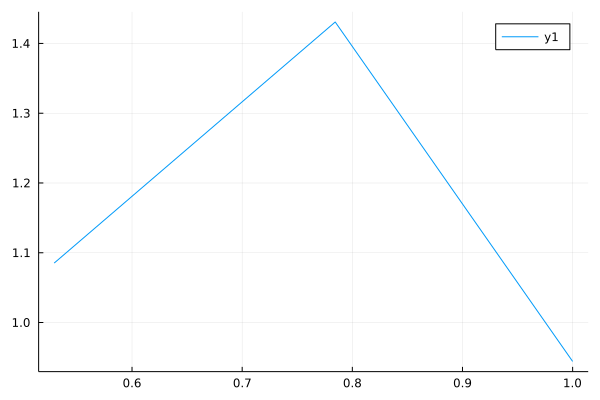

In [23]:
plot([(plot_pair[1], mean(plot_pair[2])) for plot_pair in plot_pairs])

In [ ]:
function get_fourier_meas_fn(m,n)
    true_m, meas_mat = sample_fourier(m, n)
    meas_mat = sqrt(n/true_m).*meas_mat
    return (meas_mat, x -> meas_mat*x)
end

In [ ]:
k = 1
mid = 1
n = 1
aimed_m = 1
num_signals = 2
meas_fn = get_fourier_meas_fn(aimed_m, n)[2]

β_array = [1.0]
plot_pairs = []
signal_errors = Array{Float64}(undef,num_signals)
#model, alignment = get_aligned_models(k, mid, n, [0,])[1]
model = get_rand_model(k,mid,n)
x₀ = randn(n)/sqrt(n)
measurements = meas_fn(x₀)

In [ ]:
measurements = meas_fn(x₀)
println(measurements)
x̂ = recover_signal(measurements, meas_fn, model, k)
println(meas_fn(x̂))
println(err,"   ", norm(x₀))

In [ ]:
model()

In [ ]:
k = 20
mid = 30
n = 100
aimed_m = 20
num_signals = 2
meas_fn = get_fourier_meas_fn(aimed_m, n)
β_array = 0:0.1:1
plot_pairs = []
signal_errors = Array{Float64}(undef,num_signals)
for (model, alignment) in get_aligned_models(k, mid,n, β_array)
    for i in 1:num_signals
        x₀ = randn(n)/sqrt(n)
        signal_error[i] = recovery_error(x₀, model, meas_fn, k)
    push!(plot_pairs, (alignment, mean(signal_errors)))
    end
end

In [ ]:
a = Array{Int}(undef,3)

In [ ]:
k = 20
n = 100
A = randn(n, k)
F = dct(diagm(ones(n)),2)
matrix_alignment(A, F)

In [ ]:
function plot_alignments()
    n= 500
    alignments = []
    normal_one = []
    F = dct(diagm(ones(n)),2)
    for k in 1:2:100
        A = randn(n, k)
        push!(alignments, matrix_alignment(A, F))
        push!(normal_one, sqrt(k/n))
    end
    plot(alignments)
    plot!(normal_one*0.9)
    xlabel!
    
end
plot_alignments()

In [ ]:
k = 20
n = 100
A = randn(n, k)
F = dct(diagm(ones(n)),2)
get_aligned_models

In [ ]:
for i in eachcol(A)
    println(i)
end

In [ ]:
F = dct(diagm(ones(n)),2)

In [ ]:
convert(Array,0:0.1:1.0)

In [ ]:
k = 20
mid = 100
n = 400
aimed_m = 23
num_meas, measure_mat = sample_fourier(aimed_m, n)
measure(x) = measure_mat*x
random_model = get_rand_model(k,mid,n)
#signal in range
true_signal = random_model(rand(Float64, k))
measurements = measure(true_signal);

In [ ]:
#@time recovered_signal = recover_signal(measurements, measure, random_model, k)
#println("The distance between signals is ", norm(recovered_signal - true_signal))
#println("The size of the true signal is ", norm(true_signal))

In [ ]:
function GD_CS(G, y, A, max_iter, stepsize, tolerance, out_toggle)
    _, k = size(Flux.params(G)[1])
    z = randn(k)
    iter = 1
    succ_error = 1
    d(z) = gradient(z -> norm(y - A*G(z))^2, z)[1]

    while iter <= max_iter && succ_error > tolerance
        # d gives the PLUGIn direction
        z -= stepsize * d(z)
        succ_error = norm(stepsize * d(z))
        if iter % out_toggle == 0  
            println("====> In Gradient: Iteration: $iter Successive error: $succ_error")
        end
        iter += 1
    end
    return z
end

In [ ]:
function get_aligned_model()

In the next experiment, we consider a one hidden layer network of the form $G(z) = A_2σ(A_1z)$. The inner layer matrix $A_1 \in \mathbb{R}^{n_1\times k}$ has $\mathcal{N}(0,1/n_1)$ entries. For the outer layer matrix $A_2 \in \mathbb{R}^{n_2\times n_1}$ ($n_2 = n$), we take a matrix $A_{21}$ which contains columns randomly subsampled (without replacement) from a $n\times n$ DCT matrix and a random matrix $A_{22}$ which contains $\mathcal{N}(0,1/n_2)$ entries and take its convex combination, i.e. 
$$A_2 = \beta A_{21} + (1-\beta) A_{22}$$
for $\beta \in [0,1]$.

For each $\beta \in [0.7,1]$, we attempt to recover the code vector $z_0$ from measurement of the form $y = A G(z_0)$ where $A \in \mathbb{R}^{m\times n}$ is subsampled DCT matrix (without replacement) by solve the least squares optimzation problem using the gradient descent algorithm. We show the results from 20 trials for each $\beta$ and for all trials, $z_0, A_1, A_{21}$, and $A_{22}$ are fixed. For all experiments, $k = 20, n = 400$, $n_1$ is approximately 100, and $m$ is approximately 160.

In [ ]:
#setup a synthetic problem
x_dim = 400
k = 20

# F = real(fft(diagm(ones(x_dim)),2))
F = dct(diagm(ones(x_dim)),2)

# sampling rows of DCT matrix for outer layer
sampling = rand(Bernoulli(100/x_dim), x_dim)
sampling = convert.(Int, sampling)
ndm1 = sum(sampling) #number of neurons n_1
nnzindex = []
for i in 1:length(sampling)
    if sampling[i] != 0
        push!(nnzindex, i)
    end
end

A = F[nnzindex,:]' # subsampled DCT
B = randn(x_dim, ndm1)/sqrt(x_dim) #random matrix thats used in convex combination

W1 = randn(ndm1, 20)/sqrt(ndm1) #random inner layer weight matrix

I(x) = x
z = randn(k) # ground code vector

β_list = .7:.01:1
trials = 20
recovery_error_matrix = zeros(length(β_list))
recon_error_matrix = zeros(length(β_list))
α_list = []

for trial in 1:trials
    recovery_error_list = []
    recon_error_list = []   
    α_list = []
    for β in β_list
        Aint = β*A + (1-β) * B

        #setup the generative network 
        G = Chain(
            Dense(20, ndm1, relu, bias = false; init =(out,in) -> W1),
            Dense(ndm1, x_dim, I, bias = false; init =(out,in) -> Aint)
        )

        # subsampling DCT for measurement matrix
        sampling = rand(Bernoulli(.4), x_dim)
        sampling = convert.(Int, sampling)
        m = sum(sampling)
        nnzindex = []
        for i in 1:length(sampling)
            if sampling[i] != 0
                push!(nnzindex, i)
            end
        end
        F_sub = F[nnzindex,:]*sqrt(x_dim)/sqrt(m)

        # measurement vector using subsampled DCT matrix
        y = F_sub*G(z)

        stepsize = .5
        tolerance = 1e-14
        max_iter = 2000
        out_toggle = 2001

        # run gradient descent to solve the least squares problem
        z_rec = GD_CS(G,y,F_sub, max_iter, stepsize, tolerance, out_toggle)
        recov_error = norm(z - real(z_rec))/norm(z)
        recon_error = norm(G(z) - G(real(z_rec)))/norm(G(z))
        Fn = F  
        α = maximum(sum((Fn*Aint)' .* (Fn*Aint)', dims = 1) ./ sqrt.(sum((Fn*Aint*Aint')' .* (Fn*Aint*Aint')', dims = 1)))

        # save results
        push!(recovery_error_list, recov_error)
        push!(recon_error_list, recon_error)
        push!(α_list, α)

    end
    #save results
    recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
    recon_error_matrix = hcat(recon_error_matrix, recon_error_list)


end
